In [121]:
import numpy as np
import matplotlib.pyplot as plt
from load_data import load_file
import pandas as pd
# Standard libraries
import os
import sys

# Third party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize_scalar
from scipy.optimize import root


def gen_lorentzian(x, x0, max, gamma):
    return max/(1+((x-x0)/gamma)**2)

def poly(x, intercept, coef):
    y = intercept
    for i, c in enumerate(coef):
        y += c * x**(1+i)
    
    return y

def lorentzian_fit(wavelength, data, plot=True):
    # Fit a polynomial
    order = 20
    wl = np.array(wavelength)
    data = np.array(data)
    
    # Split into three partitions
    idx_min = wl > 550
    idx_max = wl < 775
    idx_1 = (wl <= 630)
    idx_3 = (wl >= 700)
    idx_2 = idx_1 == idx_3
    idx_1 = idx_1 == idx_min
    idx_3 = idx_3 == idx_max
    
    wl1 = wl[idx_1].reshape(-1,1)
    wl2 = wl[idx_2].reshape(-1,1)
    wl3 = wl[idx_3].reshape(-1,1)
    
    data1 = data[idx_1]
    data2 = data[idx_2]
    data3 = data[idx_3]
    
    # Construct the design matrices
    X_1 = PolynomialFeatures(3, include_bias=False).fit_transform(wl1)
    X_2 = PolynomialFeatures(20, include_bias=False).fit_transform(wl2)
    X_3 = PolynomialFeatures(3, include_bias=False).fit_transform(wl3)

    # Perform the fit
    reg_1 = LinearRegression(normalize=True).fit(X_1, data1)
    intercept_1 = reg_1.intercept_
    coef_1 = reg_1.coef_
    
    reg_2 = LinearRegression(normalize=True).fit(X_2, data2)
    intercept_2 = reg_2.intercept_
    coef_2 = reg_2.coef_
    
    reg_3 = LinearRegression(normalize=True).fit(X_3, data3)
    intercept_3 = reg_3.intercept_
    coef_3 = reg_3.coef_
    
    # Plot fits
    if plot:
        fig, ax = plt.subplots(figsize=(10,6))
    
        y1 = np.zeros(wl1.shape[0])
        for i, w in enumerate(wl1):
            y1[i]  = poly(w, intercept_1, coef_1)
        ax.plot(wl1, y1, 'b')
    
        y2 = np.zeros(wl2.shape[0])
        for i, w in enumerate(wl2):
            y2[i]  = poly(w, intercept_2, coef_2)
        ax.plot(wl2, y2, 'b')
    
        y3 = np.zeros(wl3.shape[0])
        for i, w in enumerate(wl3):
            y3[i]  = poly(w, intercept_3, coef_3)
        ax.plot(wl3, y3, 'b')
    
        ax.plot(wl, data, 'r', alpha=0.5) # Real data
        plt.show()
    
    # Find maxmimum by optimizing the lin_reg.predict
    x0 = minimize_scalar(lambda x, i, c: -poly(x, i, c), method='bounded', args=(intercept_2, coef_2), bounds=(630,700))
    peak_x = x0.x
    peak_y = poly(peak_x, intercept_2, coef_2)
    
    # Find the FWHM by finding the roots to lin_reg.predict -lin_reg.predict(x0)/2
    x1 = root(lambda x, i, c: poly(x, i, c)-peak_y/2, x0=600, args=(intercept_1, coef_1))
    FWHM_1 = x1.x[0]
    x2 = root(lambda x, i, c: poly(x, i, c)-peak_y/2, x0=700, args=(intercept_3, coef_3))
    FWHM_2 = x2.x[0]
    FWHM = FWHM_2 - FWHM_1

    return peak_x, FWHM

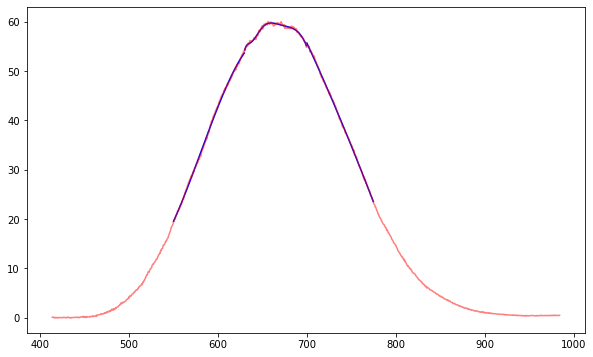

660.2934806567694
187.75718734491784


In [122]:
peak_x, FWHM = lorentzian_fit(l, corr_spectra_t)
print(peak_x)
print(FWHM)